# Question 4 - Predict Complaint Types

The goal of this exercise is to develop a model and find the answer to the fourth question of the problem statement:

*Can a predictive model be built for future prediction of the possibility of complaints of the specific type you identified in response to Question 1?*

<br>

# Introduction

We start by importing the necessary libraries and defining some useful functions. For this problem, we will only need the merged dataset we created in the last notebook.

## Libraries

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%config InlineBackend.figure_format = 'retina'

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, StratifiedKFold, learning_curve
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

label_size = 17
plt.rcParams['axes.labelsize'] = label_size
plt.rcParams['axes.titlesize'] = label_size
plt.rcParams['xtick.labelsize'] = label_size - 3  # tick labels should be smaller than axes labels (by 3 in our case)
plt.rcParams['ytick.labelsize'] = label_size - 3

random_state = 42
scoring_metric = 'accuracy'

C:\Users\ko40\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Functions

We need two functions for our task:

- **plot_learning_curve**: As the name suggests, this function plots the learning curve for our estimator/classifier,
- **clf_performance**: This function does several things. It firstly outputs the cross-validation scores for our classifier, their mean and standard deviation. It then plots a confusion matrix next to the plot for the learning curve. Finally, it returns the False Positive Rate (fpr), the True Positive Rate (tpr), and the AUC score,
- **plot_feature_imp**: The final functions plots a horizontal bar plot with each bar showing in the importance of the corresponding feature (in descending order).

In [2]:
def plot_learning_curve(estimator, estimator_name, X, y, ax, cv = None, train_sizes = np.linspace(0.1, 1.0, 5)):
                 
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv = cv, n_jobs = -1, 
                                                            train_sizes = train_sizes, scoring = 'accuracy')
    
    train_scores_mean, train_scores_std = np.mean(train_scores, axis = 1), np.std(train_scores, axis = 1)
    test_scores_mean, test_scores_std = np.mean(test_scores, axis = 1), np.std(test_scores, axis = 1)
            
    ax.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha = 0.1, color = 'dodgerblue')
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha = 0.1, color = 'darkorange')
    
    ax.plot(train_sizes, train_scores_mean, color = 'dodgerblue', marker = 'o', linestyle = '-', label = 'Training Score')
    ax.plot(train_sizes, test_scores_mean, color = 'darkorange', marker = 'o', linestyle = '-', label = 'Cross-validation Score')
    ax.set_title(estimator_name)
    ax.set_xlabel('Training Examples')
    ax.set_ylabel('Accuracy Score')
    ax.legend(loc = 'best');
    
def clf_performance(clf, clf_name):
    
    cv_scores = cross_val_score(clf, X_train, y_train, 
                                cv = StratifiedKFold(shuffle = True, random_state = random_state))
    
    print (clf_name)
    print('-------------------------------')
    print ('CV scores: ', cv_scores)
    print ('     Mean: ', np.round(cv_scores.mean(), 3))
    print ('      STD: ', np.round(cv_scores.std(), 3))
    
    y_pred_pp = cross_val_predict(clf, X_train, y_train, cv = 5, method = 'predict_proba')[:, 1]
    y_pred = y_pred_pp.round()
    
    cm = confusion_matrix(y_train, y_pred, normalize = 'true')
    
    fpr, tpr, _ = roc_curve(y_train, y_pred_pp)
    auc = roc_auc_score(y_train, y_pred_pp)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 5))
    
    sns.heatmap(cm, annot = True, cmap = 'Blues', annot_kws = {'fontsize': 18}, ax = ax1)
    ax1.set_xlabel('Predicted Label')
    ax1.set_xticks([0.5, 1.5])
    ax1.set_xticklabels(['0', '1'])
    ax1.set_ylabel('True Label') 
    ax1.set_yticks([0.5, 1.5])
    ax1.set_yticklabels(['0', '1'])
    
    plot_learning_curve(clf, clf_name, X_train, y_train, ax2, cv = StratifiedKFold(shuffle = True, random_state = random_state))
    plt.tight_layout()
    
    return fpr, tpr, auc

def plot_feature_imp(classifier, classifier_name, color, ax):

    importances = pd.DataFrame({'Feature': X.columns,
                                'Importance': np.round(classifier.feature_importances_, 3)})

    importances = importances.sort_values('Importance', ascending = True).set_index('Feature')

    importances.plot.barh(color = color, edgecolor = 'firebrick', legend = False, ax = ax)
    ax.set_title(classifier_name)
    ax.set_xlabel('Importance');

## Data

In [3]:
df = pd.read_csv('Merged_dataset.csv', index_col = 0)

print('The merged dataset has {} rows x {} columns.'.format(df.shape[0], df.shape[1]))
df.head()

The merged dataset has 87017 rows x 21 columns.


,Complaints #,Lot,ZipCode,Address,LotArea,BldgArea,ResArea,OfficeArea,RetailArea,NumBldgs,...,LotDepth,BldgDepth,YearBuilt,YearAlter1,BuiltFAR,ResidFAR,CommFAR,FacilFAR,XCoord,YCoord
0,NaN,1,10454.0,122 BRUCKNER BOULEVARD,15000,0,0,0,0,1,...,200.0,0.0,0,0,0.00,6.02,5.0,6.5,1005957.0,232162.0
1,NaN,4,10454.0,126 BRUCKNER BOULEVARD,13770,752,0,272,0,2,...,100.0,16.0,1931,1994,0.05,6.02,5.0,6.5,1006076.0,232156.0
2,NaN,10,10454.0,138 BRUCKNER BOULEVARD,35000,39375,0,0,0,1,...,200.0,200.0,1931,0,1.13,6.02,5.0,6.5,1006187.0,232036.0
3,5.0,17,10454.0,144 BRUCKNER BOULEVARD,2500,12500,12500,0,0,1,...,100.0,85.0,1931,2001,5.00,6.02,5.0,6.5,1006299.0,232033.0
4,13.0,18,10454.0,148 BRUCKNER BOULEVARD,1875,8595,6876,0,1719,1,...,75.0,70.0,1920,2009,4.58,6.02,5.0,6.5,1006363.0,232040.0


<br>

<br>

# Data Preprocessing

Before we start pre-processing our merged dataset, we will create a copy of it. 

In [4]:
df_model = df.copy()

## Missing Values

As we discussed already, some rows contain NaN values for the 'Complaints #' column. 

In [5]:
df_model.isnull().sum().sort_values(ascending = False).head(7)

Complaints #    69681
XCoord           1311
YCoord           1311
ZipCode            61
CommFAR             0
ResidFAR            0
Lot                 0
dtype: int64

We could interpret NaN values for 'Complaints #' as the corresponding building not showing any heating problems. Of course, this could be false for some buildings if the owners/tenants don’t report any problem. But we will stick to our hypothesis. 

We will fill these values with 0 and turn all non-zero values into 1, thus making 'Complaints #’ a **binary** column.

In [6]:
df_model['Complaints #'] = df_model['Complaints #'].fillna(0)
df_model['Complaints #'] = np.where(df_model['Complaints #'] > 0, 1, 0)

print('Complaints # - Value counts:')
df_model['Complaints #'].value_counts()

Complaints # - Value counts:


0    69681
1    17336
Name: Complaints #, dtype: int64

The 'XCoord', 'YCoord', and 'ZipCode' features will not be used for our models, so we don’t need to care about missing values in them.

## Feature Selection

For our models, we will use features with an absolute Spearman’s correlation coefficient higher than 0.15.

In [7]:
corr_sp = df.corr(method = 'spearman')['Complaints #'].sort_values(ascending = False)
corr_sp[np.abs(corr_sp) > 0.15].index[:]

Index(['Complaints #', 'ResArea', 'NumFloors', 'BuiltFAR', 'BldgArea',
       'BldgDepth', 'LotArea', 'ResidFAR', 'FacilFAR', 'YearAlter1', 'ZipCode',
       'XCoord'],
      dtype='object')

In [8]:
y = df_model['Complaints #']
X = df_model[['ResArea', 'NumFloors', 'BuiltFAR', 'BldgArea',
              'BldgDepth', 'LotArea', 'ResidFAR', 'FacilFAR', 'YearAlter1']] #'ZipCode' and 'XCoord' are excluded 

## Splitting Sets

In [9]:
# Split the dataset into 20% test and 80% training ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

print('X Set - Shape')
print('Train set: {} rows x {} columns'.format(X_train.shape[0], X_train.shape[1]))
print(' Test set: {} rows x {} columns'.format(X_test.shape[0], X_test.shape[1]))

X Set - Shape
Train set: 69613 rows x 9 columns
 Test set: 17404 rows x 9 columns


## Class Imbalance

There is an imbalance in the classes to be predicted, with one class (0 – No 'HEAT/HOT WATER' complaint) much more prevalent than the other (1 - at least one complaint):

In [10]:
print('y training set:')
y_train.value_counts()

y training set:


0    55693
1    13920
Name: Complaints #, dtype: int64

There are several strategies for addressing the class imbalance. Motivated from [this article](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/), I have decided first to oversample the minority class to have 50 percent of the number of instances of the majority class (e.g. 27846), then use random undersampling to reduce the number of instances in the majority class to have the same number of instances as the minority class.

To implement this, we can specify the desired ratios as arguments to the SMOTE and RandomUnderSampler classes:

In [11]:
over = SMOTE(sampling_strategy = 0.5, random_state = 42)
under = RandomUnderSampler(sampling_strategy = 1, random_state = 42)

steps = [('o', over), 
         ('u', under)]
pipeline = Pipeline(steps = steps)

X_train, y_train = pipeline.fit_resample(X_train, y_train)

print('y training set after SMOTE:')
y_train.value_counts()

y training set after SMOTE:


1    27846
0    27846
Name: Complaints #, dtype: int64

## Feature Scaling

In [12]:
scaler = StandardScaler()  

X_train = scaler.fit_transform(X_train)  
X_test = scaler.transform(X_test)

# Building a Predictive Model

We are now ready to build Machine Learning models! Specifically, we will use two classifiers: scikit-learn's `RandomForestClassifier` and xgboost's `XGBClassifier`. 

The exercise does **not** ask for hyperparameter tuning; therefore, I decided to stick to the default parameters (except for reducing the `max_depth` hyperparameter to avoid overfitting). A complete analysis would require a hyperparameter tuning step.

## Random Forest

Random Forest Classifier
-------------------------------
CV scores:  [0.75769818 0.76586767 0.76333273 0.76503861 0.75641946]
     Mean:  0.762
      STD:  0.004


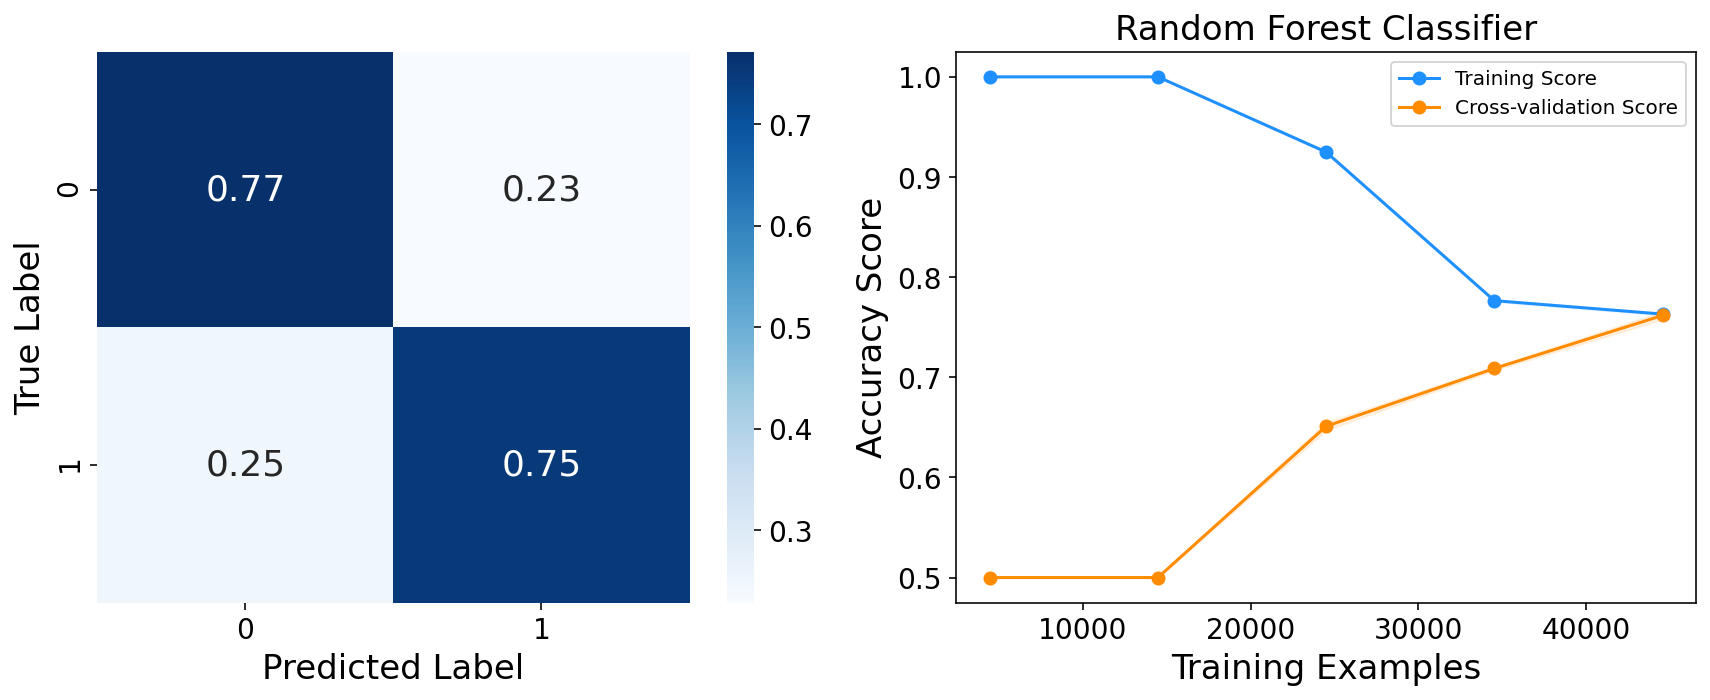

In [13]:
rf = RandomForestClassifier(max_depth = 4, random_state = random_state)

fpr_rf, tpr_rf, auc_rf = clf_performance(rf, 'Random Forest Classifier')

Our Random Forest classifier achieves an accuracy approximately equal to **76%**. Notice that it has a similar performance in classifying both 1s and 0s. Additionally, our model does **not** suffer from overfitting at the end of training.

## XGBClassifier

XGB
-------------------------------
CV scores:  [0.81973247 0.8174881  0.81325193 0.8222302  0.81414976]
     Mean:  0.817
      STD:  0.003


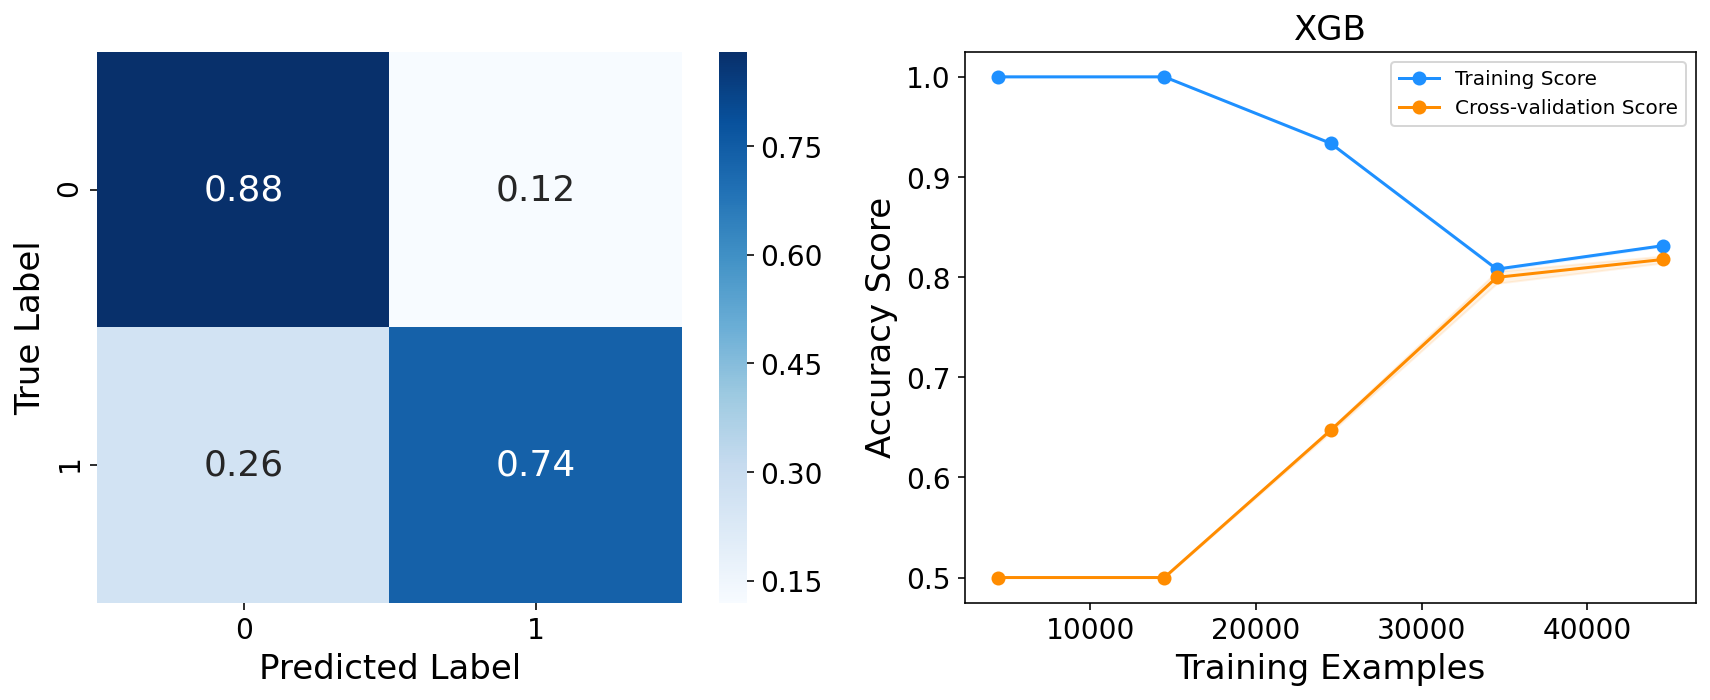

In [14]:
xgb = XGBClassifier(max_depth = 4, random_state = random_state)

fpr_xgb, tpr_xgb, auc_xgb = clf_performance(xgb, 'XGB')

The XGB classifier has higher accuracy (~ **82%**), but it performs better when classifying 0s. There is a small gap between the curves at the end of training, which we could easily close by regularising our model further.

## ROC Curve

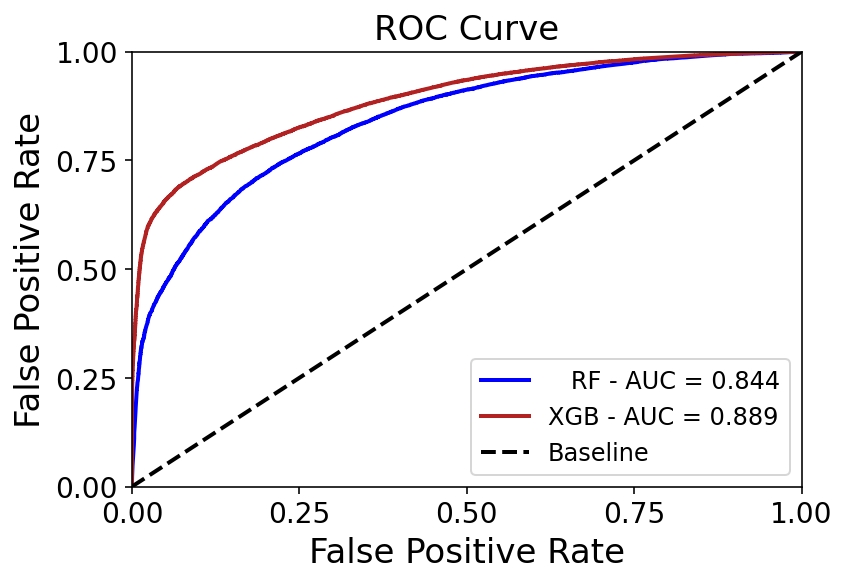

In [15]:
plt.plot(fpr_rf, tpr_rf, color = 'b', lw = 2, label = '   RF - AUC = {}'.format(np.round(auc_rf, 3)))
plt.plot(fpr_xgb, tpr_xgb, color = 'firebrick', lw = 2, label = 'XGB - AUC = {}'.format(np.round(auc_xgb, 3)))

plt.plot([0, 1], [0, 1], 'k--', lw = 2, label = 'Baseline')

plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.xlim([0, 1])
plt.xticks([0, 0.25, 0.5, 0.75, 1])
plt.ylabel('False Positive Rate')
plt.ylim([0, 1])
plt.yticks([0, 0.25, 0.5, 0.75, 1])
plt.legend(fontsize = 12);

The ROC curve is another way of comparing the two classifiers. The XGB classifier is superior to the Random Forest classifier because its ROC curve is much closer to the top-left corner (or similarly, further away from the baseline random classifier). As a result, its area under the ROC curve (AUC) is also better.

## Feature Importance

In [16]:
rf.fit(X_train, y_train)
xgb.fit(X_train, y_train);

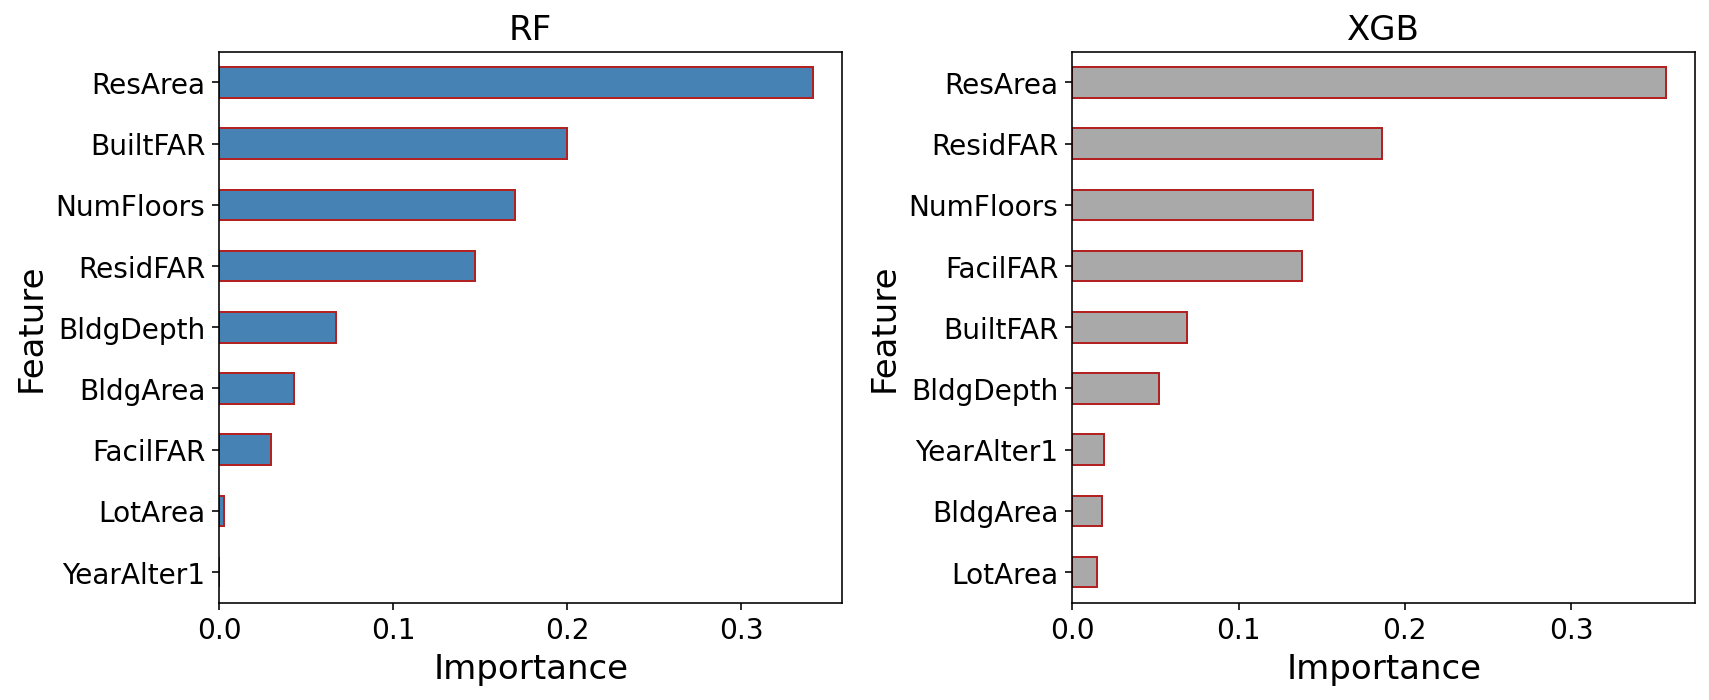

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 5))

plot_feature_imp(rf, 'RF', 'steelblue', ax1)
plot_feature_imp(xgb, 'XGB', 'darkgray', ax2)

plt.tight_layout();

'ResArea' is the most important feature for both classifiers. Moreover, features 'BuiltFAR', 'NumFloors', and 'ResidFAR' rank high in importance. On the other hand, 'YearAlter' and 'LotArea' do not seem that critical for our predictive models. 

## Performance on the Test Set

In [18]:
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print('RF - Accuracy = ', np.round(accuracy_score(y_test, y_pred), 3))

RF - Accuracy =  0.758


In [19]:
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

print('XGB - Accuracy = ', np.round(accuracy_score(y_test, y_pred), 3))

XGB - Accuracy =  0.827


We have already mentioned that our models do **not** suffer from overfitting. Consequently, it's not a surprise that their performance on the test set is similar to the training set.

<br>

# Future Development

There are several things that we could improve:

- Feature Engineering,
- Different techniques for addressing the class imbalance,
- Add more classifiers,
- Perform hyperparameter tuning and find the optimal set of hyperparameters. 

<br>

# Conclusions

In this notebook, we built **two predictive models** for future prediction of the possibility of getting a 'HEAT/HOT WATER' complaint in the Bronx. Our models are based on typical building characteristics such as the number of floors, residential and lot area, the building's year, etc. The **XGB classifier** (accuracy **~ 82%**) performs better than the Random Forest classifier (accuracy ~ 76%).

<br>

---

# Quiz

## Question 1

Can the model that you developed use Number of Floors in an address as a possible predictive feature?

Answer: Yes, our models use it. The number of floors essentially means that more people are using the building, which can be a reason for a heating complaint.

## Question 2

Although you are developing a model for a particular Complaint Type, you can use data for other complaint types to build the model?

Answer: No. The characteristics and reasons for a complaint type are different from other characteristics.

## Question 3

The features that you can use to build the model can come from which datasets? Select all that apply.

- Complaint dataset
- PLUTO dataset
- Any other dataset

Answer: All three.